In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

In [5]:

wti_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/wti.csv")

wti_data['Date'] = pd.to_datetime(wti_data['Date'])

wti_data = wti_data[wti_data['Date'] >= '1998-01-01']

wti_data = wti_data.reset_index(drop=True)
wti_data


,Date,WTI Spot Price
0,1990-01-02,22.88
1,1990-01-03,23.81
2,1990-01-04,23.41
3,1990-01-05,23.07
4,1990-01-08,21.64
...,...,...
8415,2023-06-13,69.39
8416,2023-06-14,68.22
8417,2023-06-15,70.61
8418,2023-06-16,71.81


In [104]:
ny_gasoline_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/ny_gasoline.csv")

ny_gasoline_data['Date'] = pd.to_datetime(ny_gasoline_data['Date'])

ny_gasoline_data = ny_gasoline_data[ny_gasoline_data['Date'] >= '1998-01-01']

ny_gasoline_data = ny_gasoline_data.reset_index(drop=True)


In [103]:
la_diesel_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/la_diesel.csv")

la_diesel_data['Date'] = pd.to_datetime(la_diesel_data['Date'])

la_diesel_data = la_diesel_data[la_diesel_data['Date'] >= '1998-01-01']

la_diesel_data = la_diesel_data.reset_index(drop=True)


In [106]:
heating_oil_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/ny_heating_oil.csv")

heating_oil_data['Date'] = pd.to_datetime(heating_oil_data['Date'])

heating_oil_data = heating_oil_data[heating_oil_data['Date'] >= '1998-01-01']

heating_oil_data.reset_index(drop=True, inplace=True)




In [105]:
x_propane_data = pd.read_csv("https://raw.githubusercontent.com/easyyliu/mining_collections/main/tx_propane.csv")

x_propane_data['Date'] = pd.to_datetime(x_propane_data['Date'])

x_propane_data = x_propane_data[x_propane_data['Date'] >= '1998-01-01']

x_propane_data = x_propane_data.reset_index(drop=True)


In [107]:
merged_data = pd.merge(wti_data, ny_gasoline_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, la_diesel_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, heating_oil_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, x_propane_data, on='Date', how='outer')

merged_data = merged_data.sort_values('Date')
merged_data['Index'] = merged_data.reset_index().index
date_data = merged_data['Date']
merged_data = merged_data.drop('Date', axis=1)
merged_data = merged_data.apply(pd.to_numeric, errors='coerce')
imputer = KNNImputer(n_neighbors=3)
merged_data = imputer.fit_transform(merged_data)

merged_data = pd.DataFrame(merged_data, columns=['wti', 'ny gasoline', 'la diesel', 'ny heating oil', 'tx propane'])
merged_data = merged_data.sort_values('Index')
date_data = date_data.sort_values()
sorted_date = date_data.reset_index(drop=True)
merged_data['date'] = sorted_date
merged_data = merged_data.drop('Index', axis=1)
merged_data = merged_data.reindex(columns=['date', 'wti', 'ny gasoline', 'la diesel', 'ny heating oil', 'tx propane'])
merged_data.head()

,date,wti,brent,ny gasoline,gulf gasoline,heating oil
0,1990-01-02,22.88,21.20,0.668,0.657,0.951
1,1990-01-03,23.81,22.65,0.691,0.730,1.012
2,1990-01-04,23.41,22.50,0.671,0.706,0.967
3,1990-01-05,23.07,23.13,0.642,0.665,0.874
4,1990-01-08,21.64,21.38,0.608,0.618,0.809


In [108]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# import matplotlib.pyplot as plt


# train = merged_data[merged_data['date'] < '2021-01-01']
# test = merged_data[(merged_data['date'] >= '2021-01-01') & (merged_data['date'] <= '2023-06-01')]

# # Convert dates to ordinal values
# train['Date_Ordinal'] = train['date'].apply(lambda x: x.toordinal())
# test['Date_Ordinal'] = test['date'].apply(lambda x: x.toordinal())
# # Drop the original date column if needed
# train = train.drop('date', axis=1)
# test = test.drop('date', axis=1)

# # 定义输入特征和目标变量
# X_train = train.drop('ny gasoline', axis=1)
# y_train = train['ny gasoline']

# X_test = test.drop('ny gasoline', axis=1)
# y_test = test['ny gasoline']


# #GradientBoostingRegressor model training


# model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, loss='squared_error')

# model.fit(X_train, y_train)

# y_pred_GBR = model.predict(X_test)


# # 创建并训练模型
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# # 进行预测
# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# # 计算并打印训练集和测试集的均方根误差
# rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print(f'Train RMSE: {rmse_train:.2f}')
# print(f'Test RMSE: {rmse_test:.2f}')

# # 创建并训练线性回归模型
# linear_model = LinearRegression()
# linear_model.fit(X_train, y_train)

# # 进行预测
# y_pred_train_linear = linear_model.predict(X_train)
# y_pred_test_linear = linear_model.predict(X_test)

# # 计算并打印训练集和测试集的均方根误差
# rmse_train_linear = np.sqrt(mean_squared_error(y_train, y_pred_train_linear))
# rmse_test_linear = np.sqrt(mean_squared_error(y_test, y_pred_test_linear))

# print(f'Linear Regression Train RMSE: {rmse_train_linear:.2f}')
# print(f'Linear Regression Test RMSE: {rmse_test_linear:.2f}')

# # 创建并训练决策树回归模型
# tree_model = DecisionTreeRegressor(random_state=42)
# tree_model.fit(X_train, y_train)

# # 进行预测
# y_pred_train_tree = tree_model.predict(X_train)
# y_pred_test_tree = tree_model.predict(X_test)

# # 计算并打印训练集和测试集的均方根误差
# rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_pred_train_tree))
# rmse_test_tree = np.sqrt(mean_squared_error(y_test, y_pred_test_tree))

# print(f'Decision Tree Train RMSE: {rmse_train_tree:.2f}')
# print(f'Decision Tree Test RMSE: {rmse_test_tree:.2f}')


# from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

# # 计算线性回归模型的评估指标
# mae_linear = mean_absolute_error(y_test, y_pred_test_linear)
# r2_linear = r2_score(y_test, y_pred_test_linear)
# evs_linear = explained_variance_score(y_test, y_pred_test_linear)

# print(f'Linear Regression Test MAE: {mae_linear:.2f}')
# print(f'Linear Regression Test R^2: {r2_linear:.2f}')
# print(f'Linear Regression Test EVS: {evs_linear:.2f}')

# # 计算决策树回归模型的评估指标
# mae_tree = mean_absolute_error(y_test, y_pred_test_tree)
# r2_tree = r2_score(y_test, y_pred_test_tree)
# evs_tree = explained_variance_score(y_test, y_pred_test_tree)

# print(f'Decision Tree Test MAE: {mae_tree:.2f}')
# print(f'Decision Tree Test R^2: {r2_tree:.2f}')
# print(f'Decision Tree Test EVS: {evs_tree:.2f}')


# from sklearn.svm import SVR

# # 创建并训练支持向量机回归模型
# #svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# #svm_model.fit(X_train, y_train)

# # 进行预测
# #y_pred_train_svm = svm_model.predict(X_train)
# #y_pred_test_svm = svm_model.predict(X_test)

# # 计算并打印训练集和测试集的均方根误差
# #rmse_train_svm = np.sqrt(mean_squared_error(y_train, y_pred_train_svm))
# #rmse_test_svm = np.sqrt(mean_squared_error(y_test, y_pred_test_svm))

# #print(f'SVM Train RMSE: {rmse_train_svm:.2f}')
# #print(f'SVM Test RMSE: {rmse_test_svm:.2f}')

# # 计算其他的评估指标
# #mae_svm = mean_absolute_error(y_test, y_pred_test_svm)
# #r2_svm = r2_score(y_test, y_pred_test_svm)
# #evs_svm = explained_variance_score(y_test, y_pred_test_svm)

# #print(f'SVM Test MAE: {mae_svm:.2f}')
# #print(f'SVM Test R^2: {r2_svm:.2f}')
# #print(f'SVM Test EVS: {evs_svm:.2f}')



# # 创建日期索引
# dates_test = pd.to_datetime(test['Date_Ordinal'])

# # 创建画布
# fig, ax = plt.subplots(figsize=(10, 6))

# # 绘制真实价格折线图
# ax.plot(dates_test, y_test, label='Actual Price')

# # 绘制线性回归模型的预测价格折线图
# ax.plot(dates_test, y_pred_test_linear, label='Linear Regression Predicted Price')

# # 绘制决策树回归模型的预测价格折线图
# ax.plot(dates_test, y_pred_test_tree, label='Decision Tree Predicted Price')

# # 绘制支持向量机回归模型的预测价格折线图
# #ax.plot(dates_test, y_pred_test_svm, label='Support Vector Machine Predicted Price')

# #GBR
# ax.plot(dates_test, y_pred_GBR, label='Gradient Boosting Regressor Predicted Price')

# # 设置图例和标题
# ax.legend()
# ax.set_xlabel('Date')
# ax.set_ylabel('Price')
# ax.set_title('Actual vs Predicted Price')

# # 自动旋转日期标签以提高可读性
# fig.autofmt_xdate()

# # 显示图表
# plt.show()



# # 创建散点图
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_test_linear)
# plt.xlabel('Actual Price')
# plt.ylabel('Linear Regression Predicted Price')
# plt.title('Actual vs Predicted Price (Linear Regression)')
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_test_tree)
# plt.xlabel('Actual Price')
# plt.ylabel('Decision Tree Predicted Price')
# plt.title('Actual vs Predicted Price (Decision Tree)')
# plt.show()

# #plt.figure(figsize=(10, 6))
# #plt.scatter(y_test, y_pred_test_svm)
# #plt.xlabel('Actual Price')
# #plt.ylabel('Support Vector Machine Predicted Price')
# #plt.title('Actual vs Predicted Price (Support Vector Machine)')
# #plt.show()

# # 创建直方图
# plt.figure(figsize=(10, 6))
# plt.hist(y_test, bins=20, alpha=0.5, label='Actual Price')
# plt.hist(y_pred_test_linear, bins=20, alpha=0.5, label='Linear Regression Predicted Price')
# plt.xlabel('Price')
# plt.ylabel('Frequency')
# plt.title('Price Distribution')
# plt.legend()
# plt.show()

# # 创建误差图
# #plt.figure(figsize=(10, 6))
# #plt.plot(dates_test, y_test - y_pred_test_linear, label='Linear Regression Error')
# #plt.plot(dates_test, y_test - y_pred_test_tree, label='Decision Tree Error')
# #plt.plot(dates_test, y_test - y_pred_test_svm, label='Support Vector Machine Error')
# #plt.xlabel('Date')
# #plt.ylabel('Error')
# #plt.title('Prediction Error')
# #plt.legend()
# #plt.show()

# # 创建箱线图
# plt.figure(figsize=(10, 6))
# #plt.boxplot([y_test, y_pred_test_linear, y_pred_test_tree, y_pred_test_svm], labels=['Actual Price', 'Linear Regression', 'Decision Tree', 'Support Vector Machine'])
# plt.boxplot([y_test, y_pred_test_linear, y_pred_test_tree], labels=['Actual Price', 'Linear Regression', 'Decision Tree'])
# plt.ylabel('Price')
# plt.title('Price Comparison')
# plt.show()

In [109]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# import matplotlib.pyplot as plt

# # 划分训练集和测试集
# train = merged_data[merged_data['date'] < '2021-01-01']
# test = merged_data[(merged_data['date'] >= '2021-01-01') & (merged_data['date'] <= '2023-06-01')]

# # 转换日期
# train['Date_Ordinal'] = train['date'].apply(lambda x: x.toordinal())
# test['Date_Ordinal'] = test['date'].apply(lambda x: x.toordinal())
# train = train.drop('date', axis=1)
# test = test.drop('date', axis=1)

# # 定义输入特征和目标变量
# X_train = train.drop('ny gasoline', axis=1)
# y_train = train['ny gasoline']

# X_test = test.drop('ny gasoline', axis=1)
# y_test = test['ny gasoline']

# # GradientBoostingRegressor模型训练和预测
# model_GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, loss='squared_error')
# model_GBR.fit(X_train, y_train)
# y_pred_GBR = model_GBR.predict(X_test)

# # 随机森林回归模型训练和预测
# model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
# model_RF.fit(X_train, y_train)
# y_pred_RF_train = model_RF.predict(X_train)
# y_pred_RF_test = model_RF.predict(X_test)

# # 线性回归模型训练和预测
# model_LR = LinearRegression()
# model_LR.fit(X_train, y_train)
# y_pred_LR_train = model_LR.predict(X_train)
# y_pred_LR_test = model_LR.predict(X_test)

# # 决策树回归模型训练和预测
# model_DT = DecisionTreeRegressor(random_state=42)
# model_DT.fit(X_train, y_train)
# y_pred_DT_train = model_DT.predict(X_train)
# y_pred_DT_test = model_DT.predict(X_test)

# # 计算并打印训练集和测试集的均方根误差
# rmse_train_RF = np.sqrt(mean_squared_error(y_train, y_pred_RF_train))
# rmse_test_RF = np.sqrt(mean_squared_error(y_test, y_pred_RF_test))
# rmse_train_LR = np.sqrt(mean_squared_error(y_train, y_pred_LR_train))
# rmse_test_LR = np.sqrt(mean_squared_error(y_test, y_pred_LR_test))
# rmse_train_DT = np.sqrt(mean_squared_error(y_train, y_pred_DT_train))
# rmse_test_DT = np.sqrt(mean_squared_error(y_test, y_pred_DT_test))

# print(f'Random Forest Train RMSE: {rmse_train_RF:.2f}')
# print(f'Random Forest Test RMSE: {rmse_test_RF:.2f}')

# print(f'Linear Regression Train RMSE: {rmse_train_LR:.2f}')
# print(f'Linear Regression Test RMSE: {rmse_test_LR:.2f}')

# print(f'Decision Tree Train RMSE: {rmse_train_DT:.2f}')
# print(f'Decision Tree Test RMSE: {rmse_test_DT:.2f}')

# # 创建日期索引
# dates_test = pd.to_datetime(test['Date_Ordinal'])

# # 创建画布
# fig, ax = plt.subplots(figsize=(10, 6))

# # 绘制真实价格折线图
# ax.plot(dates_test, y_test, label='Actual Price')

# # 绘制线性回归模型的预测价格折线图
# ax.plot(dates_test, y_pred_LR_test, label='Linear Regression Predicted Price')

# # 绘制决策树回归模型的预测价格折线图
# ax.plot(dates_test, y_pred_DT_test, label='Decision Tree Predicted Price')

# # 绘制GradientBoostingRegressor模型的预测价格折线图
# ax.plot(dates_test, y_pred_GBR, label='Gradient Boosting Regressor Predicted Price')

# # 设置图例和标题
# ax.legend()
# ax.set_xlabel('Date')
# ax.set_ylabel('Price')
# ax.set_title('Actual vs Predicted Price')

# # 自动旋转日期标签以提高可读性
# fig.autofmt_xdate()

# # 显示图表
# plt.show()

# # 创建散点图
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_LR_test)
# plt.xlabel('Actual Price')
# plt.ylabel('Linear Regression Predicted Price')
# plt.title('Actual vs Predicted Price (Linear Regression)')
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_DT_test)
# plt.xlabel('Actual Price')
# plt.ylabel('Decision Tree Predicted Price')
# plt.title('Actual vs Predicted Price (Decision Tree)')
# plt.show()

# # 创建直方图
# plt.figure(figsize=(10, 6))
# plt.hist(y_test, bins=20, alpha=0.5, label='Actual Price')
# plt.hist(y_pred_LR_test, bins=20, alpha=0.5, label='Linear Regression Predicted Price')
# plt.xlabel('Price')
# plt.ylabel('Frequency')
# plt.title('Price Distribution')
# plt.legend()
# plt.show()

# # 创建箱线图
# plt.figure(figsize=(10, 6))
# plt.boxplot([y_test, y_pred_LR_test, y_pred_DT_test, y_pred_GBR], labels=['Actual Price', 'Linear Regression', 'Decision Tree', 'Gradient Boosting Regressor'])
# plt.ylabel('Price')
# plt.title('Price Comparison')
# plt.show()


/var/folders/sw/k8lw996d10zg2xkswhlxc1b40000gn/T/ipykernel_56538/1750127039.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date_Ordinal'] = train['date'].apply(lambda x: x.toordinal())
/var/folders/sw/k8lw996d10zg2xkswhlxc1b40000gn/T/ipykernel_56538/1750127039.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date_Ordinal'] = test['date'].apply(lambda x: x.toordinal())


Random Forest Train RMSE: 0.01
Random Forest Test RMSE: 0.22
Linear Regression Train RMSE: 0.06
Linear Regression Test RMSE: 0.14
Decision Tree Train RMSE: 0.00
Decision Tree Test RMSE: 0.29


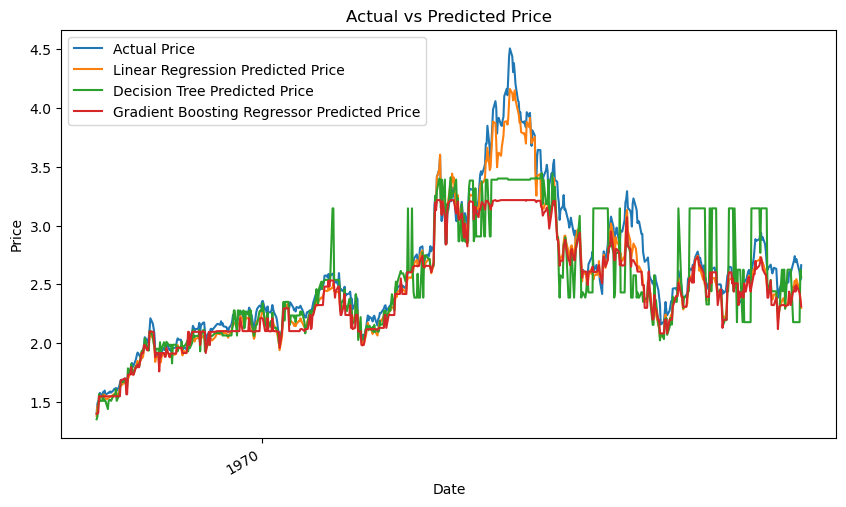

Random Forest Train RMSE: 0.01
Random Forest Test RMSE: 0.22


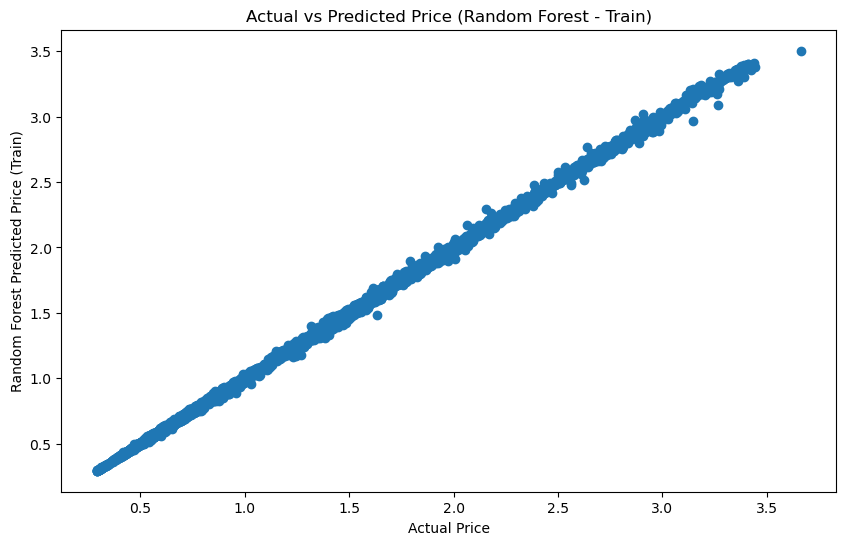

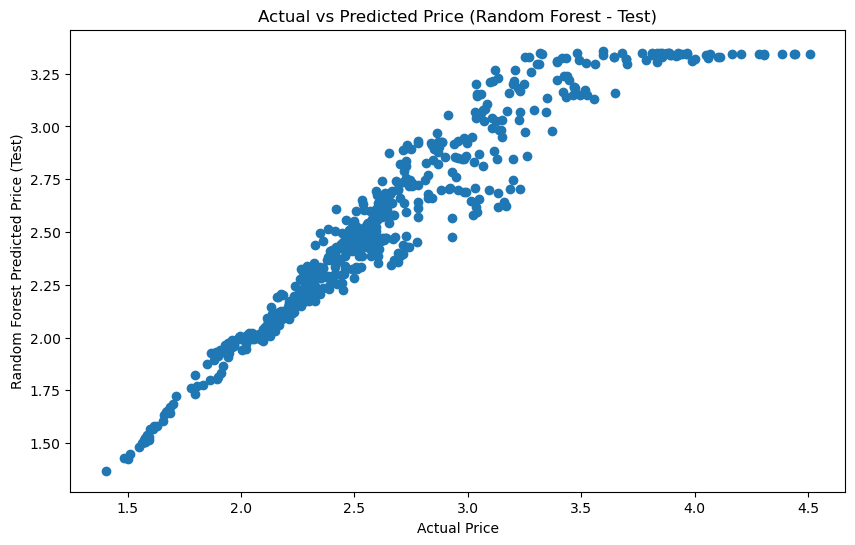

Linear Regression Train RMSE: 0.06
Linear Regression Test RMSE: 0.14


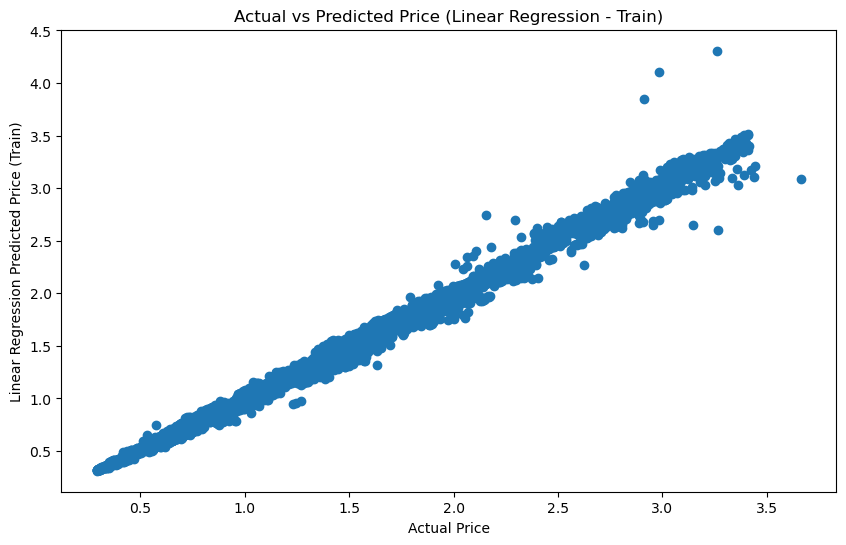

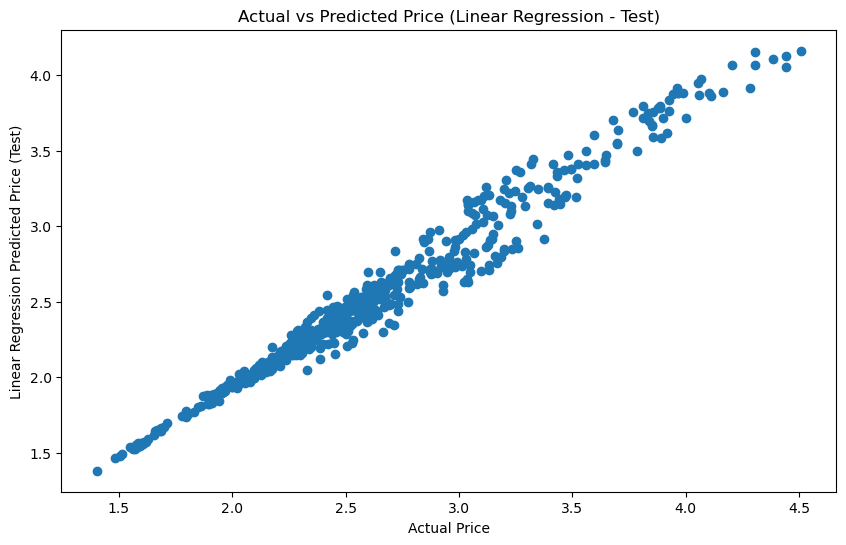

Decision Tree Train RMSE: 0.00
Decision Tree Test RMSE: 0.29


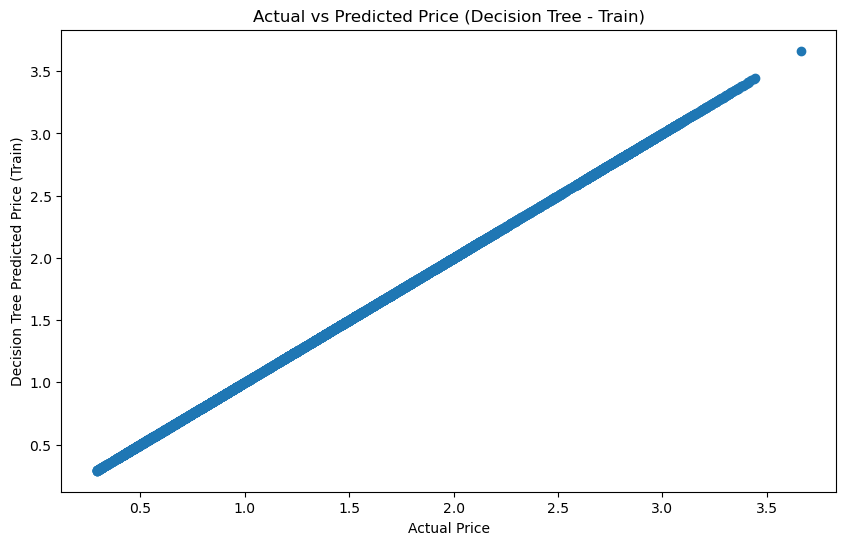

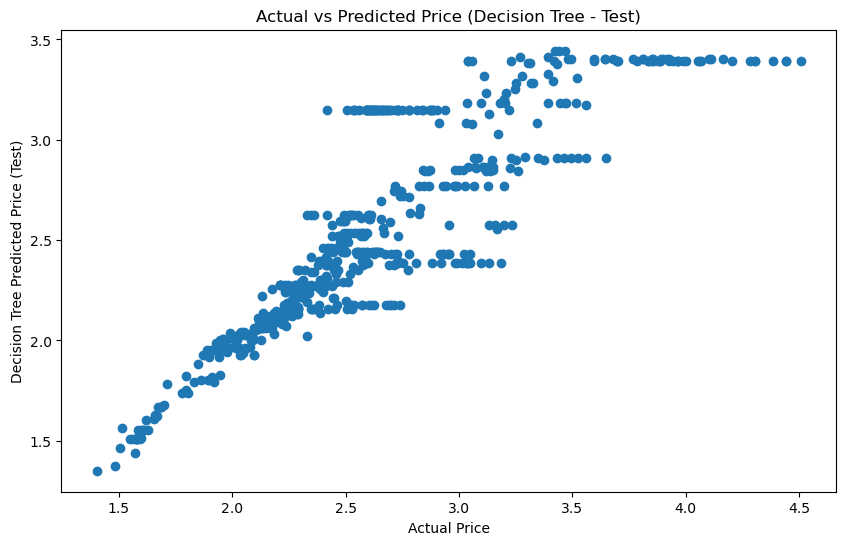

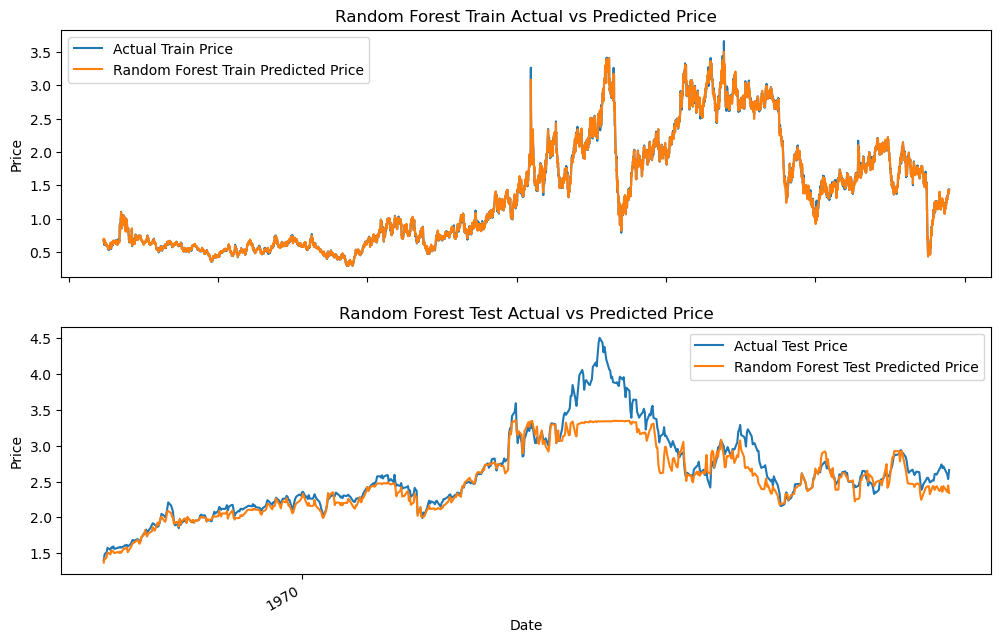

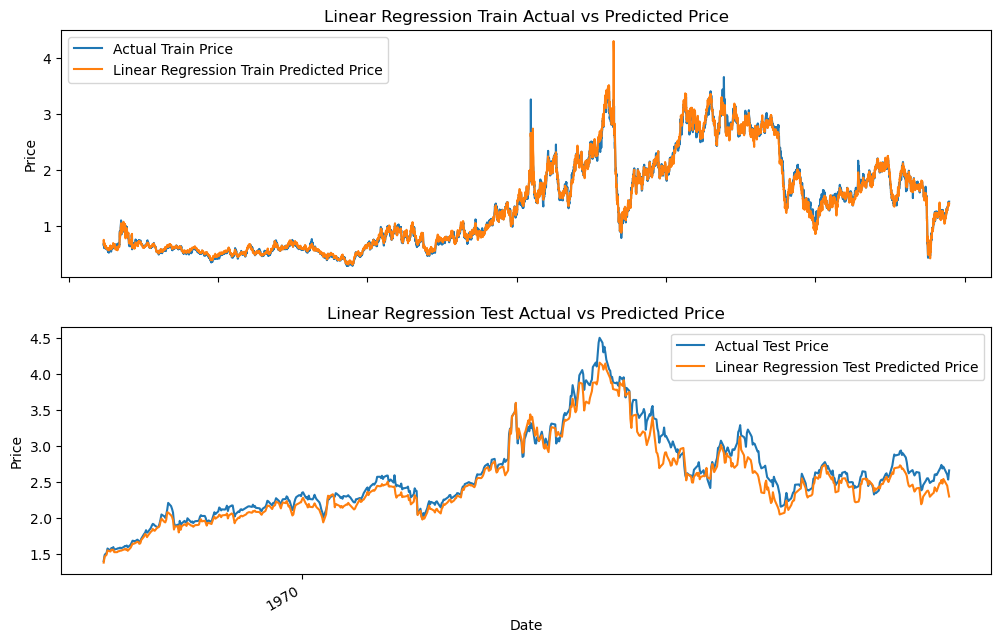

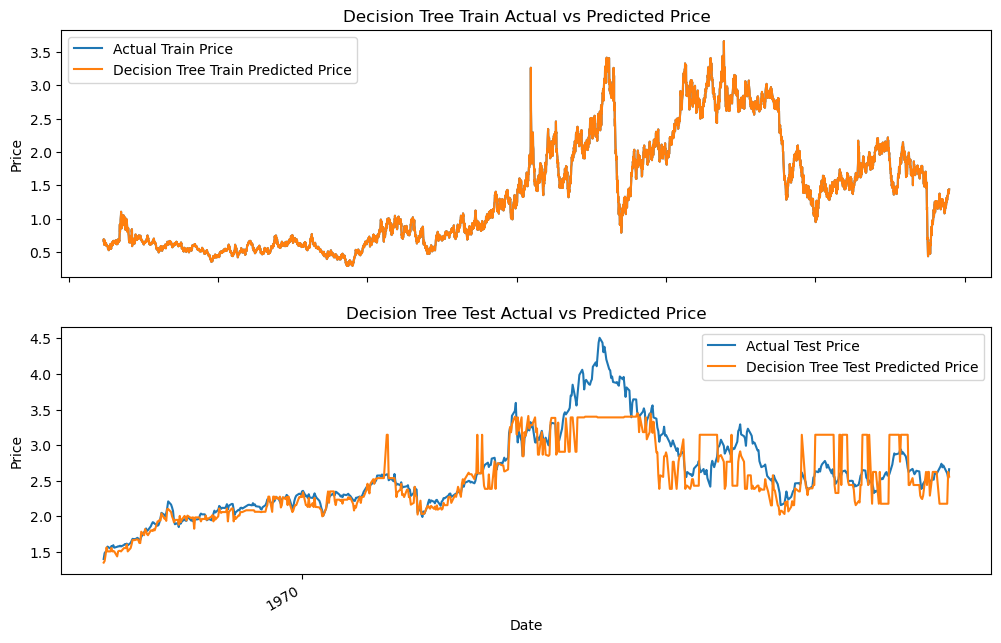

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# 划分训练集和测试集
train = merged_data[merged_data['date'] < '2021-01-01']
test = merged_data[(merged_data['date'] >= '2021-01-01') & (merged_data['date'] <= '2023-06-01')]

# 转换日期
train['Date_Ordinal'] = train['date'].apply(lambda x: x.toordinal())
test['Date_Ordinal'] = test['date'].apply(lambda x: x.toordinal())
train = train.drop('date', axis=1)
test = test.drop('date', axis=1)

# 定义输入特征和目标变量
X_train = train[['wti', 'brent', 'gulf gasoline', 'heating oil']]
y_train = train['ny gasoline']

X_test = test[['wti', 'brent', 'gulf gasoline', 'heating oil']]
y_test = test['ny gasoline']

# GradientBoostingRegressor模型训练和预测
model_GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, loss='squared_error')
model_GBR.fit(X_train, y_train)
y_pred_GBR = model_GBR.predict(X_test)

# 随机森林回归模型训练和预测
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_RF.fit(X_train, y_train)
y_pred_RF_train = model_RF.predict(X_train)
y_pred_RF_test = model_RF.predict(X_test)

# 线性回归模型训练和预测
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred_LR_train = model_LR.predict(X_train)
y_pred_LR_test = model_LR.predict(X_test)

# 决策树回归模型训练和预测
model_DT = DecisionTreeRegressor(random_state=42)
model_DT.fit(X_train, y_train)
y_pred_DT_train = model_DT.predict(X_train)
y_pred_DT_test = model_DT.predict(X_test)

# 计算并打印训练集和测试集的均方根误差
rmse_train_RF = np.sqrt(mean_squared_error(y_train, y_pred_RF_train))
rmse_test_RF = np.sqrt(mean_squared_error(y_test, y_pred_RF_test))
rmse_train_LR = np.sqrt(mean_squared_error(y_train, y_pred_LR_train))
rmse_test_LR = np.sqrt(mean_squared_error(y_test, y_pred_LR_test))
rmse_train_DT = np.sqrt(mean_squared_error(y_train, y_pred_DT_train))
rmse_test_DT = np.sqrt(mean_squared_error(y_test, y_pred_DT_test))

print(f'Random Forest Train RMSE: {rmse_train_RF:.2f}')
print(f'Random Forest Test RMSE: {rmse_test_RF:.2f}')

print(f'Linear Regression Train RMSE: {rmse_train_LR:.2f}')
print(f'Linear Regression Test RMSE: {rmse_test_LR:.2f}')

print(f'Decision Tree Train RMSE: {rmse_train_DT:.2f}')
print(f'Decision Tree Test RMSE: {rmse_test_DT:.2f}')

# 创建日期索引
dates_test = pd.to_datetime(test['Date_Ordinal'])

# 创建画布
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制真实价格折线图
ax.plot(dates_test, y_test, label='Actual Price')

# 绘制线性回归模型的预测价格折线图
ax.plot(dates_test, y_pred_LR_test, label='Linear Regression Predicted Price')

# 绘制决策树回归模型的预测价格折线图
ax.plot(dates_test, y_pred_DT_test, label='Decision Tree Predicted Price')

# 绘制GradientBoostingRegressor模型的预测价格折线图
ax.plot(dates_test, y_pred_GBR, label='Gradient Boosting Regressor Predicted Price')

# 设置图例和标题
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Actual vs Predicted Price')

# 自动旋转日期标签以提高可读性
fig.autofmt_xdate()

# 显示图表
plt.show()



# 打印Random Forest模型的训练集和测试集RMSE
print(f'Random Forest Train RMSE: {rmse_train_RF:.2f}')
print(f'Random Forest Test RMSE: {rmse_test_RF:.2f}')

# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_RF_train)
plt.xlabel('Actual Price')
plt.ylabel('Random Forest Predicted Price (Train)')
plt.title('Actual vs Predicted Price (Random Forest - Train)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_RF_test)
plt.xlabel('Actual Price')
plt.ylabel('Random Forest Predicted Price (Test)')
plt.title('Actual vs Predicted Price (Random Forest - Test)')
plt.show()

# 打印Linear Regression模型的训练集和测试集RMSE
print(f'Linear Regression Train RMSE: {rmse_train_LR:.2f}')
print(f'Linear Regression Test RMSE: {rmse_test_LR:.2f}')

# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_LR_train)
plt.xlabel('Actual Price')
plt.ylabel('Linear Regression Predicted Price (Train)')
plt.title('Actual vs Predicted Price (Linear Regression - Train)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_LR_test)
plt.xlabel('Actual Price')
plt.ylabel('Linear Regression Predicted Price (Test)')
plt.title('Actual vs Predicted Price (Linear Regression - Test)')
plt.show()

# 打印Decision Tree模型的训练集和测试集RMSE
print(f'Decision Tree Train RMSE: {rmse_train_DT:.2f}')
print(f'Decision Tree Test RMSE: {rmse_test_DT:.2f}')

# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_DT_train)
plt.xlabel('Actual Price')
plt.ylabel('Decision Tree Predicted Price (Train)')
plt.title('Actual vs Predicted Price (Decision Tree - Train)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_DT_test)
plt.xlabel('Actual Price')
plt.ylabel('Decision Tree Predicted Price (Test)')
plt.title('Actual vs Predicted Price (Decision Tree - Test)')
plt.show()




# 创建日期索引
dates_train = pd.to_datetime(train['Date_Ordinal'])

# 创建Random Forest模型的训练集和测试集预测结果图表
fig_RF, axs_RF = plt.subplots(2, 1, figsize=(12, 8))

axs_RF[0].plot(dates_train, y_train, label='Actual Train Price')
axs_RF[0].plot(dates_train, y_pred_RF_train, label='Random Forest Train Predicted Price')
axs_RF[0].set_xlabel('Date')
axs_RF[0].set_ylabel('Price')
axs_RF[0].set_title('Random Forest Train Actual vs Predicted Price')
axs_RF[0].legend()

axs_RF[1].plot(dates_test, y_test, label='Actual Test Price')
axs_RF[1].plot(dates_test, y_pred_RF_test, label='Random Forest Test Predicted Price')
axs_RF[1].set_xlabel('Date')
axs_RF[1].set_ylabel('Price')
axs_RF[1].set_title('Random Forest Test Actual vs Predicted Price')
axs_RF[1].legend()

# 自动旋转日期标签以提高可读性
fig_RF.autofmt_xdate()

# 显示图表
plt.show()


# 创建Linear Regression模型的训练集和测试集预测结果图表
fig_LR, axs_LR = plt.subplots(2, 1, figsize=(12, 8))

axs_LR[0].plot(dates_train, y_train, label='Actual Train Price')
axs_LR[0].plot(dates_train, y_pred_LR_train, label='Linear Regression Train Predicted Price')
axs_LR[0].set_xlabel('Date')
axs_LR[0].set_ylabel('Price')
axs_LR[0].set_title('Linear Regression Train Actual vs Predicted Price')
axs_LR[0].legend()

axs_LR[1].plot(dates_test, y_test, label='Actual Test Price')
axs_LR[1].plot(dates_test, y_pred_LR_test, label='Linear Regression Test Predicted Price')
axs_LR[1].set_xlabel('Date')
axs_LR[1].set_ylabel('Price')
axs_LR[1].set_title('Linear Regression Test Actual vs Predicted Price')
axs_LR[1].legend()

# 自动旋转日期标签以提高可读性
fig_LR.autofmt_xdate()

# 显示图表
plt.show()


# 创建Decision Tree模型的训练集和测试集预测结果图表
fig_DT, axs_DT = plt.subplots(2, 1, figsize=(12, 8))

axs_DT[0].plot(dates_train, y_train, label='Actual Train Price')
axs_DT[0].plot(dates_train, y_pred_DT_train, label='Decision Tree Train Predicted Price')
axs_DT[0].set_xlabel('Date')
axs_DT[0].set_ylabel('Price')
axs_DT[0].set_title('Decision Tree Train Actual vs Predicted Price')
axs_DT[0].legend()

axs_DT[1].plot(dates_test, y_test, label='Actual Test Price')
axs_DT[1].plot(dates_test, y_pred_DT_test, label='Decision Tree Test Predicted Price')
axs_DT[1].set_xlabel('Date')
axs_DT[1].set_ylabel('Price')
axs_DT[1].set_title('Decision Tree Test Actual vs Predicted Price')
axs_DT[1].legend()

# 自动旋转日期标签以提高可读性
fig_DT.autofmt_xdate()

# 显示图表
plt.show()
